# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Read-imcat-output-final.cat" data-toc-modified-id="Read-imcat-output-final.cat-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read imcat output final.cat</a></div><div class="lev1 toc-item"><a href="#Create-new-columns" data-toc-modified-id="Create-new-columns-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create new columns</a></div><div class="lev1 toc-item"><a href="#Look-all-Files-for-gm_sq-between-0.7-and-1.0" data-toc-modified-id="Look-all-Files-for-gm_sq-between-0.7-and-1.0-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Look all Files for gm_sq between 0.7 and 1.0</a></div><div class="lev1 toc-item"><a href="#Original-fitsfiles-obtained-from-jedisim" data-toc-modified-id="Original-fitsfiles-obtained-from-jedisim-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Original fitsfiles obtained from jedisim</a></div>

# Introduction

Date: July 25, 2019 Mon

1. In jedisim we used ngals = 10k, z = 1.5 and did 100 simulations. jedisim gives l,l9,m,m9 for each 100 simulations respectively for lsst, lsst90, monochormatic and monochromatic90 cases. In jedisim we have total 100*4 = 400 fits files.

2. From jedisim we get l.fits file and from this file using dmstack we get l.csv file. From 400 jedisim output fitsfiles, we get 400 dmstack output csv files. Each dmstack output csv file has 90 flags and 76 parameters, i.e. in total it has 90+76 = 166 columns such as fluxes, ellipticities and so on.

3. After dmstack we clean and filter l.csv to get l.txt which have no nans, e <= 1.5,
   is not a psf candidate and have no child.
   This file has only few columns: FileNumber(fN), id, x-y, errx-erry, e1-e2, sdssFlux.
   
4. We use these four l.txt, l9.txt, m.txt, m9.txt file in IMCAT and get final0.cat and combine 100 finalXX.cat files to get final.cat.

5. This lc catalog file final.cat (or its text conversion final_text.txt) has more columns than single final0.cat.
   ```
   fN    00 10 20 30  # fN means file number
   id    00 10 20 30
   flux  00 10 20 30

   x  0 1
   gm 0 1
   gc 0 1
   
   errx 00 01 10 11 20 21 30 31
   g    00 01 10 11 20 21 30 31 # there is no erry here in imcat output
   
   So, in total there are
   3 * 4 + 3 * 2 + 2 * 8 = 8 + 6 + 16 = 34 columns in final.cat file.
   ```
   
   
**Previous Work** 
- The big file final_text.txt has about 200k lines. One row of this file is obtained for combination of l.csv, l9.csv, m.csv, m9.csv.
- I made a flux column by combining these 4 fluxes to one flux so that each row has one total flux column for its four files.
- Now, I sorted the data according to flux and binned the data into N_BUCKETS so that each bucket 
  has approx equal number of objects. Then I plotted gm_sq value for each bin.
- Problem: For middle bins (e.g 24,25,26) there are too many objects in the squared reduced shear range of 0.7 to
  1.0 (i.e. 0.7 < gm_sq < 1.0)
  
**Purpose**
- Now, I will see the distribution of ellipticities in each file.
   

# Read imcat output final.cat

In [1]:
!head -2 final_text.txt

#       fN[0][0]       fN[1][0]       fN[2][0]       fN[3][0]       id[0][0]       id[1][0]       id[2][0]       id[3][0]           x[0]           x[1]     errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]     errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]        g[0][0]        g[0][1]        g[1][0]        g[1][1]        g[2][0]        g[2][1]        g[3][0]        g[3][1]     flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]          gm[0]          gm[1]          gc[0]          gc[1]
               0              0              0              0           5678           5735           5568           5678      1969.2159      2159.7569         0.1046         0.0759         0.1063         0.0745         0.1055         0.0759          0.107         0.0746          1.083        -0.2341         1.1499        -0.4244         1.1705        -0.2617         1.2105        -0.4458      8119.9753      8214.5911      8109.6423      8206.3494        1.11645       -0.32925       

In [2]:
# find number of lines
!wc -l final_text.txt

  183837 final_text.txt


In [3]:
# !tail -2 final_text.txt

In [4]:
# Now we will read file using pandas

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import scipy
import scipy.stats as stats

# Jupyter notebook settings for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100) # None for all the rows
pd.set_option('display.max_colwidth', 500)

# %load_ext version_information
# %version_information numpy,  scipy, pandas, sklearn, matplotlib, seaborn

In [6]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [7]:
# columns names
infile = 'final_text.txt'
headers = pd.read_csv(infile,sep=r'\s+',nrows=1).columns

headers = headers[1:] # remove first # column

print(len(headers))
headers

34


Index(['fN[0][0]', 'fN[1][0]', 'fN[2][0]', 'fN[3][0]', 'id[0][0]', 'id[1][0]',
       'id[2][0]', 'id[3][0]', 'x[0]', 'x[1]', 'errx[0][0]', 'errx[0][1]',
       'errx[1][0]', 'errx[1][1]', 'errx[2][0]', 'errx[2][1]', 'errx[3][0]',
       'errx[3][1]', 'g[0][0]', 'g[0][1]', 'g[1][0]', 'g[1][1]', 'g[2][0]',
       'g[2][1]', 'g[3][0]', 'g[3][1]', 'flux[0][0]', 'flux[1][0]',
       'flux[2][0]', 'flux[3][0]', 'gm[0]', 'gm[1]', 'gc[0]', 'gc[1]'],
      dtype='object')

In [8]:
df = pd.read_csv(infile,sep=r'\s+',comment='#',header=None)
df.columns = headers
print(df.shape)
df.head().append(df.tail())

(183836, 34)


,fN[0][0],fN[1][0],fN[2][0],fN[3][0],id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],errx[2][0],errx[2][1],errx[3][0],errx[3][1],g[0][0],g[0][1],g[1][0],g[1][1],g[2][0],g[2][1],g[3][0],g[3][1],flux[0][0],flux[1][0],flux[2][0],flux[3][0],gm[0],gm[1],gc[0],gc[1]
0,0,0,0,0,5678,5735,5568,5678,1969.21590,2159.75690,0.1046,0.0759,0.1063,0.0745,0.1055,0.0759,0.1070,0.0746,1.0830,-0.2341,1.1499,-0.4244,1.1705,-0.2617,1.2105,-0.4458,8119.9753,8214.5911,8109.6423,8206.3494,1.11645,-0.32925,1.19050,-0.35375
1,0,0,0,0,3181,3193,3164,3179,2222.70820,480.46175,0.0084,0.0080,0.0078,0.0086,0.0083,0.0080,0.0078,0.0086,0.4174,0.6428,-0.2249,-0.5265,0.4378,0.6521,-0.2665,-0.5215,53940.3420,53844.2740,53930.3800,53825.1630,0.09625,0.05815,0.08565,0.06530
2,0,0,0,0,617,629,634,631,2490.22380,808.50175,0.1954,0.2183,0.1988,0.2101,0.1967,0.2164,0.1999,0.2103,-0.5360,-0.2100,-0.0658,-0.7159,-0.6352,-0.1759,-0.0540,-0.5692,1992.9584,2009.3786,1981.6793,2005.1267,-0.30090,-0.46295,-0.34460,-0.37255
3,0,0,0,0,684,696,699,698,3373.27020,905.54893,0.0547,0.0594,0.0549,0.0592,0.0547,0.0594,0.0550,0.0591,-0.6025,-0.0211,0.2921,-0.1267,-0.6900,-0.0190,0.3317,-0.3053,6554.3191,6547.4142,6556.4337,6549.9094,-0.15520,-0.07390,-0.17915,-0.16215
4,0,0,0,0,7439,7449,7225,7379,469.49428,3091.40550,0.1649,0.1191,0.1122,0.1652,0.1660,0.1190,0.1129,0.1656,0.8693,-0.5821,-0.8425,0.6476,0.8742,-0.5830,-0.8725,0.6541,5283.5760,5059.5502,5279.9345,5064.7001,0.01340,0.03275,0.00085,0.03555
183831,99,99,99,99,5387,1434,5361,1433,198.25002,1952.60110,0.0199,0.0229,0.0214,0.0222,0.0201,0.0232,0.0217,0.0224,-0.1756,0.0527,0.0542,-0.0354,-0.1891,0.0470,0.0650,-0.0333,91211.4160,95316.0400,91447.8030,95605.5920,-0.06070,0.00865,-0.06205,0.00685
183832,99,99,99,99,4334,4299,4299,4278,630.99595,1181.56760,0.0881,0.1280,0.1192,0.0947,0.0883,0.1290,0.1205,0.0952,-0.7639,0.1458,0.6898,-0.2447,-0.7954,0.1456,0.7218,-0.2520,7831.6692,7884.9631,7830.4413,7881.9131,-0.03705,-0.04945,-0.03680,-0.05320
183833,99,99,99,99,6633,6637,6567,6553,1210.92570,2715.88440,0.2620,0.2049,0.2049,0.2817,0.2805,0.2047,0.2062,0.2745,0.8274,0.2520,-0.5229,-0.4550,0.8344,0.3958,-0.4943,-0.2969,3009.3663,3277.0883,3642.4290,3457.6310,0.15225,-0.10150,0.17005,0.04945
183834,99,99,99,99,7429,7423,7347,7327,628.17332,3170.70070,0.0252,0.0236,0.0136,0.0172,0.0174,0.0145,0.0137,0.0173,0.4518,-0.5612,-0.4099,0.6419,0.4638,-0.5750,-0.4214,0.6486,65430.3410,65042.7170,65522.9630,65130.2340,0.02095,0.04035,0.02120,0.03680
183835,99,99,99,99,3565,487,3546,486,1012.99140,668.48905,0.1321,0.1634,0.2443,0.2245,0.1336,0.1664,0.1650,0.1341,0.0185,0.7450,0.3311,0.3349,0.0605,0.7665,0.3397,0.3455,7363.0329,8192.7381,7288.0971,7581.0610,0.17480,0.53995,0.20010,0.55600


# Create new columns

In [9]:
# Find total flux, gm**2 and gc**2
df['flux'] = df['flux[0][0]'] + df['flux[1][0]'] + df['flux[2][0]'] + df['flux[3][0]']
df['gm_sq'] = df['gm[0]']**2 + df['gm[1]']**2
df['gc_sq'] = df['gc[0]']**2 + df['gc[1]']**2
df.head()

,fN[0][0],fN[1][0],fN[2][0],fN[3][0],id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],errx[2][0],errx[2][1],errx[3][0],errx[3][1],g[0][0],g[0][1],g[1][0],g[1][1],g[2][0],g[2][1],g[3][0],g[3][1],flux[0][0],flux[1][0],flux[2][0],flux[3][0],gm[0],gm[1],gc[0],gc[1],flux,gm_sq,gc_sq
0,0,0,0,0,5678,5735,5568,5678,1969.21590,2159.75690,0.1046,0.0759,0.1063,0.0745,0.1055,0.0759,0.1070,0.0746,1.0830,-0.2341,1.1499,-0.4244,1.1705,-0.2617,1.2105,-0.4458,8119.9753,8214.5911,8109.6423,8206.3494,1.11645,-0.32925,1.19050,-0.35375,32650.5581,1.354866,1.542429
1,0,0,0,0,3181,3193,3164,3179,2222.70820,480.46175,0.0084,0.0080,0.0078,0.0086,0.0083,0.0080,0.0078,0.0086,0.4174,0.6428,-0.2249,-0.5265,0.4378,0.6521,-0.2665,-0.5215,53940.3420,53844.2740,53930.3800,53825.1630,0.09625,0.05815,0.08565,0.06530,215540.1590,0.012645,0.011600
2,0,0,0,0,617,629,634,631,2490.22380,808.50175,0.1954,0.2183,0.1988,0.2101,0.1967,0.2164,0.1999,0.2103,-0.5360,-0.2100,-0.0658,-0.7159,-0.6352,-0.1759,-0.0540,-0.5692,1992.9584,2009.3786,1981.6793,2005.1267,-0.30090,-0.46295,-0.34460,-0.37255,7989.1430,0.304864,0.257543
3,0,0,0,0,684,696,699,698,3373.27020,905.54893,0.0547,0.0594,0.0549,0.0592,0.0547,0.0594,0.0550,0.0591,-0.6025,-0.0211,0.2921,-0.1267,-0.6900,-0.0190,0.3317,-0.3053,6554.3191,6547.4142,6556.4337,6549.9094,-0.15520,-0.07390,-0.17915,-0.16215,26208.0764,0.029548,0.058387
4,0,0,0,0,7439,7449,7225,7379,469.49428,3091.40550,0.1649,0.1191,0.1122,0.1652,0.1660,0.1190,0.1129,0.1656,0.8693,-0.5821,-0.8425,0.6476,0.8742,-0.5830,-0.8725,0.6541,5283.5760,5059.5502,5279.9345,5064.7001,0.01340,0.03275,0.00085,0.03555,20687.7608,0.001252,0.001265


# Look all Files for gm_sq between 0.7 and 1.0

In [10]:
df_07_10 = df.query("0.7 < gm_sq < 1.0")
print(df_07_10.shape)
df_07_10.head(2)

(18390, 37)


,fN[0][0],fN[1][0],fN[2][0],fN[3][0],id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],errx[2][0],errx[2][1],errx[3][0],errx[3][1],g[0][0],g[0][1],g[1][0],g[1][1],g[2][0],g[2][1],g[3][0],g[3][1],flux[0][0],flux[1][0],flux[2][0],flux[3][0],gm[0],gm[1],gc[0],gc[1],flux,gm_sq,gc_sq
14,0,0,0,0,3941,3957,3897,3923,3214.45390,930.33603,0.0344,0.0212,0.0331,0.0232,0.0344,0.0212,0.0332,0.0232,0.9068,0.3231,0.7867,0.3391,0.9179,0.3265,0.7956,0.3416,33913.5470,34112.9040,33903.5430,34114.7980,0.84675,0.33110,0.85675,0.33405,136044.7920,0.826613,0.845610
15,0,0,0,0,2989,3017,2985,2998,241.95747,382.21350,0.2170,0.1772,0.2240,0.2016,0.2177,0.1782,0.2237,0.2028,0.5205,0.7550,0.2951,0.7435,0.5345,0.7687,0.2995,0.7436,3841.8326,3891.8063,3834.4907,3881.8783,0.40780,0.74925,0.41700,0.75615,15450.0079,0.727676,0.745652


In [30]:
df_07_10_counts = df_07_10.groupby('fN[0][0]')['gm_sq'].count()
df_07_10_counts.name = 'bad_density_count'
df_07_10_counts.nlargest(10)

fN[0][0]
21    228
61    219
3     216
62    216
17    209
48    209
53    208
58    208
68    208
79    205
Name: bad_density_count, dtype: int64

In [31]:
df_07_10_counts.nlargest(10).sort_index()
# NOTE: fN[0][0] fN[i][0] four columns have the same values. so we can use any of them.
# these file numbers have highest object density in 0.7 < gm_sq < 1.0

fN[0][0]
3     216
17    209
21    228
48    209
53    208
58    208
61    219
62    216
68    208
79    205
Name: bad_density_count, dtype: int64

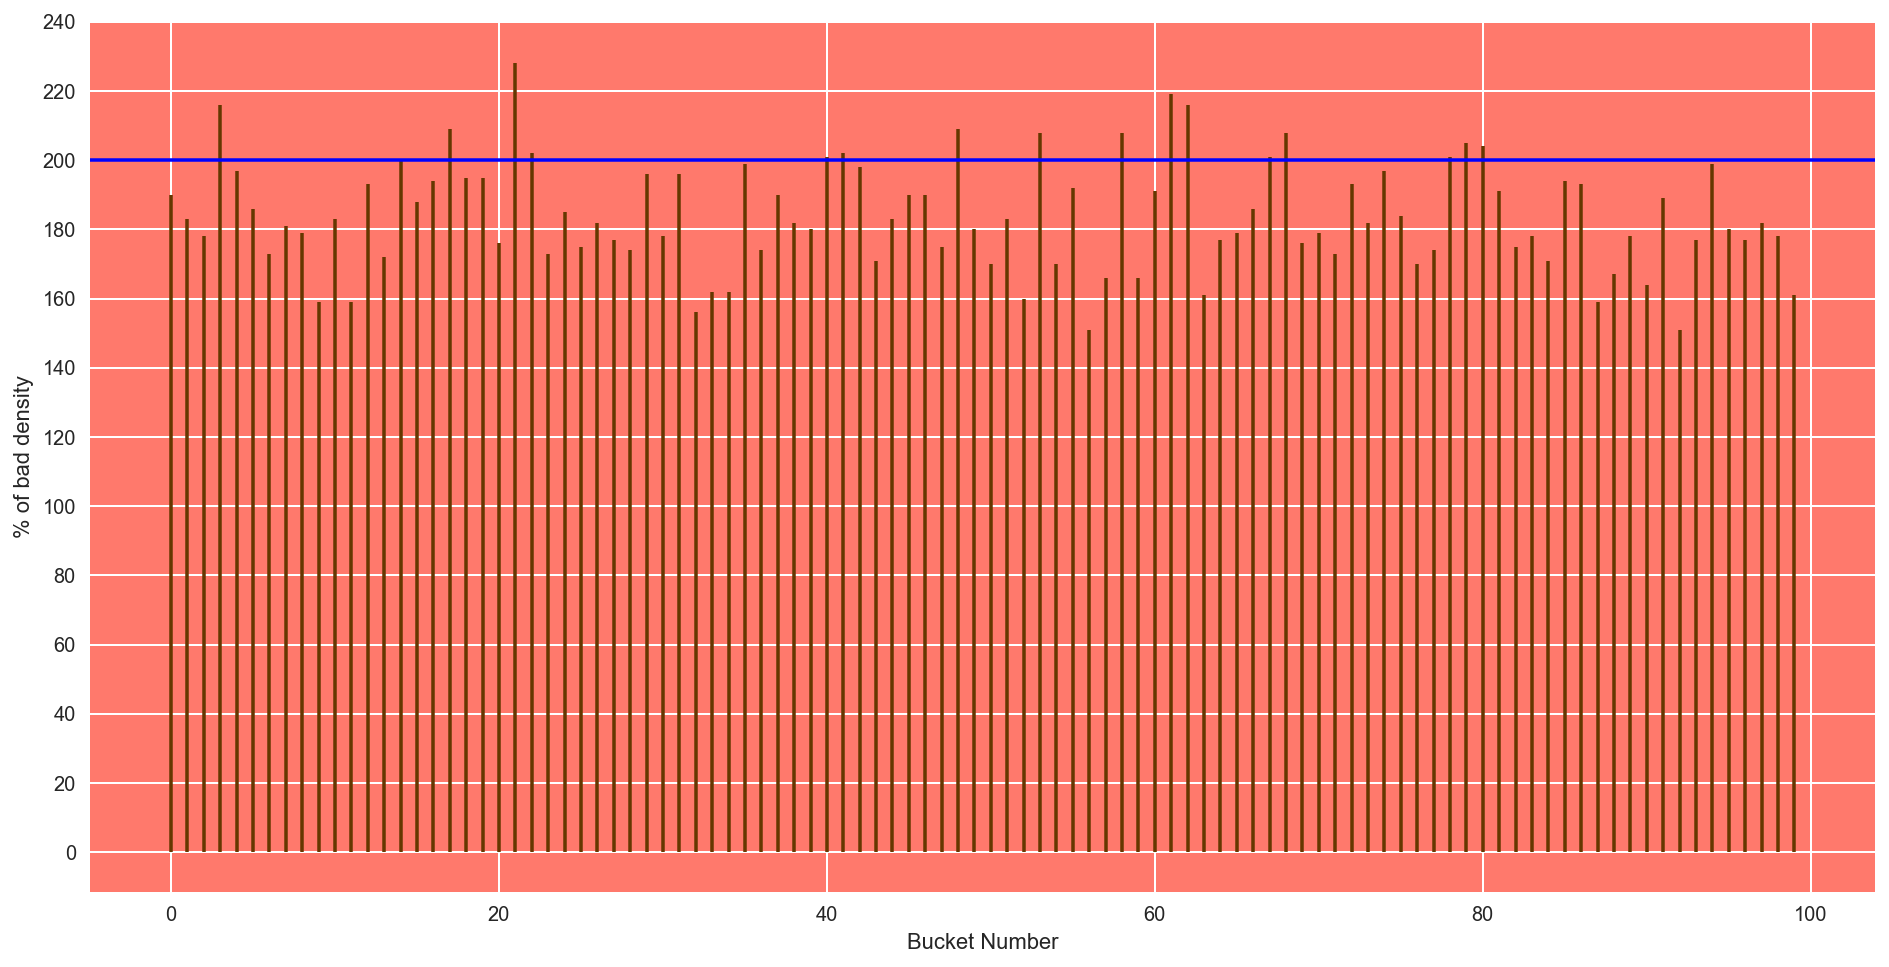

In [32]:
x = df_07_10_counts.values
x_pos = np.arange(len(x))

fig,ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('xkcd:salmon')

plt.vlines(x_pos,ymin=np.zeros_like(x), ymax=x,color='xkcd:brown')
plt.xlabel('Bucket Number')
plt.ylabel('% of bad density')
plt.axhline(y=200,color='blue')
plt.yticks(np.arange(0,260,20));

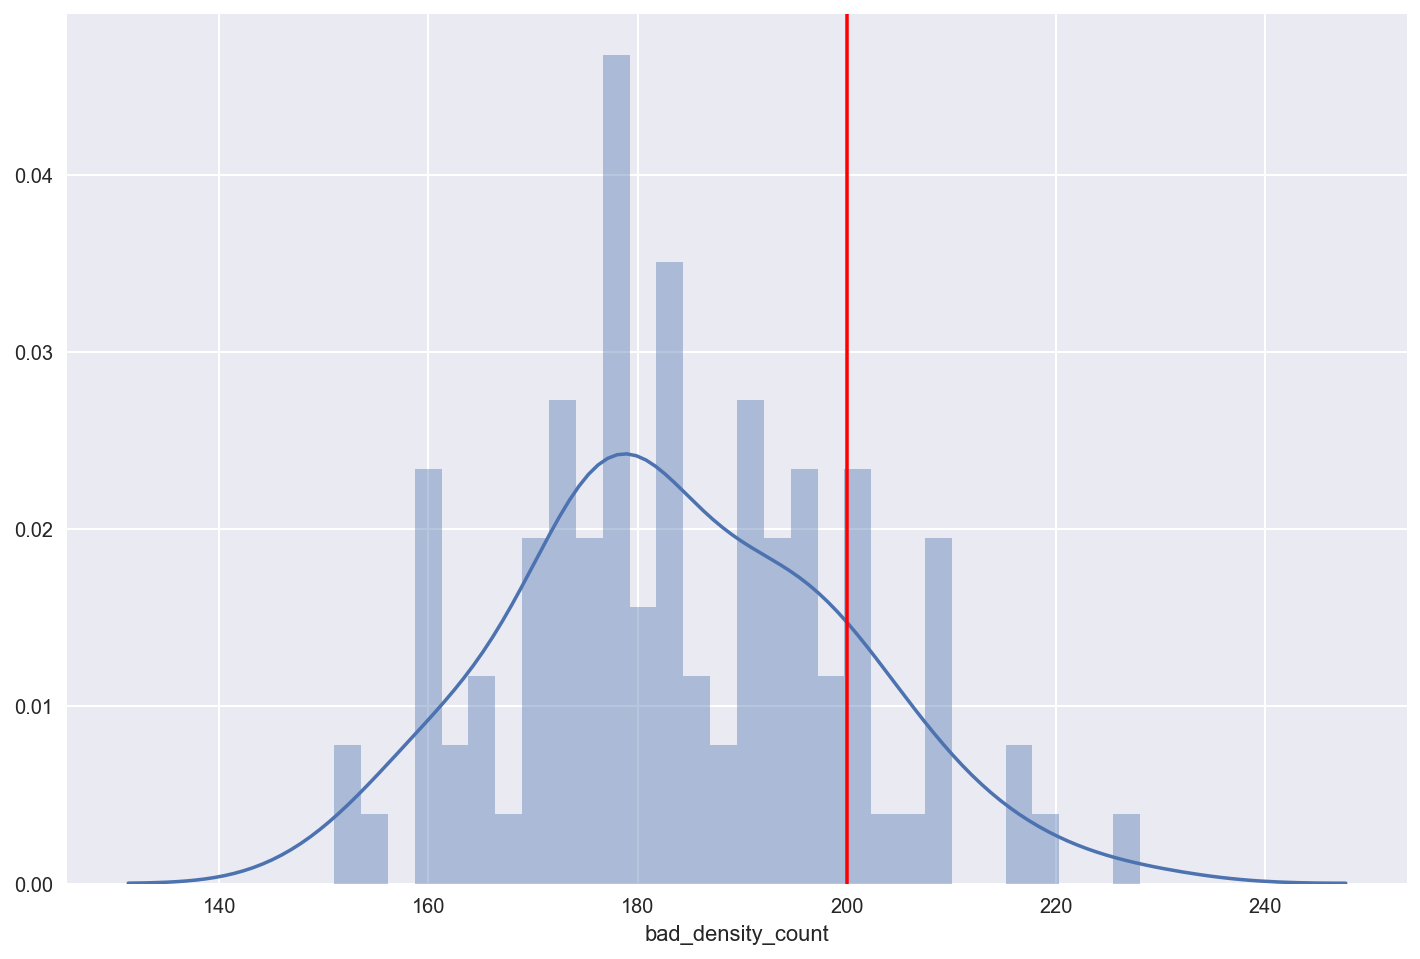

In [33]:
plt.figure(figsize=(12,8))
sns.distplot(df_07_10_counts,bins=30)
plt.axvline(x=200,color='red')

In [34]:
print(df_07_10_counts[df_07_10_counts>200].shape) # num of files having more than 200 bad density 0.7 to 1.0
df_07_10_counts[df_07_10_counts>200]

(16,)


fN[0][0]
3     216
17    209
21    228
22    202
40    201
41    202
48    209
53    208
58    208
61    219
62    216
67    201
68    208
78    201
79    205
80    204
Name: bad_density_count, dtype: int64

In [35]:
df_07_10_counts.nlargest(10).sort_index().index.values

array([ 3, 17, 21, 48, 53, 58, 61, 62, 68, 79])

In [17]:
pre = 'lsst_mono_z1.5.fits'

In [18]:
max_count_fN = 3

In [19]:
for l in ['lsst','lsst90','mono','mono90']:
    print('The file ' + l + '_z1.5_{0:03d}.fits has highest density 0.7 < gm_sq < 1.0'.format(max_count_fN))

The file lsst_z1.5_003.fits has highest density 0.7 < gm_sq < 1.0
The file lsst90_z1.5_003.fits has highest density 0.7 < gm_sq < 1.0
The file mono_z1.5_003.fits has highest density 0.7 < gm_sq < 1.0
The file mono90_z1.5_003.fits has highest density 0.7 < gm_sq < 1.0


# Original fitsfiles obtained from jedisim

- Github link:  https://github.com/bpJedisim/jout_z1.5_000_099
- Example file: https://github.com/bpJedisim/jout_z1.5_000_099/blob/master/lsst/lsst_z1.5_003.fits   
- Example file: https://github.com/bpJedisim/jout_z1.5_000_099/blob/master/lsst90/lsst90_z1.5_003.fits  

In [20]:
%%bash
#%%writefile SomeFitsFiles/download_fits_github.sh
#!/bin/bash 
declare -a LSST=("lsst" "lsst90" "lsst_mono" "lsst_mono90")
declare -a NUMS=(3 17 21)

pre=" https://github.com/bpJedisim/jout_z1.5_000_099/blob/master/"
lst="lsst/lsst_z1.5_003.fits"

for l in "${LSST[@]}"
do
    for num in "${NUMS[@]}"
    do 
        n=$(printf "%03d" $num)
        name="${pre}""${l}/""${l}_z1.5_""${n}".fits
        # Note: Do not use "$name" for wget, it gives error then.
        # -nc is no clobber
        #wget -nc ${name}
        echo $name
        break # do not use break in actual code, its just to display few rows in jupyter
    done
done

https://github.com/bpJedisim/jout_z1.5_000_099/blob/master/lsst/lsst_z1.5_003.fits
https://github.com/bpJedisim/jout_z1.5_000_099/blob/master/lsst90/lsst90_z1.5_003.fits
https://github.com/bpJedisim/jout_z1.5_000_099/blob/master/lsst_mono/lsst_mono_z1.5_003.fits
https://github.com/bpJedisim/jout_z1.5_000_099/blob/master/lsst_mono90/lsst_mono90_z1.5_003.fits


In [36]:
# !open .